# Import python packages

In [1]:
from run_ruan import Ruan

import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import random

np.random.seed(7)

# Define parameters and load bgp_routes and ToR datasets

In [2]:
ToR_MODEL_NAME = "CAIDA_s1_ToR_Classification_Ruan"

TEST_SIZE = 0.2
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}
class_names = ['P2P', 'C2P', 'P2C']
DATA_PATH = '../../Data/'
MODELS_PATH = '../../Models/'
RESULTS_PATH = '../../Results/'


bgp_routes = np.load(DATA_PATH + "bgp_routes_dataset.npy")
bgp_routes_labels = np.load(DATA_PATH + "bgp_routes_labels.npy")
print(bgp_routes.shape, bgp_routes_labels.shape)

DATA = "caida_s1_tor"
tor_dataset = np.load(DATA_PATH + DATA + "_dataset.npy")
tor_labels = np.load(DATA_PATH + DATA + "_labels.npy")

print(tor_dataset.shape, tor_labels.shape)

(3669655,) (3669655,)
(580762, 2) (580762,)


# Generate training and test sets
## Shauffle dataset

In [3]:
from sklearn.utils import shuffle
dataset, labels = shuffle(tor_dataset, tor_labels, random_state=7)

## Generate a balanced dataset

In [ ]:
# def generate_balanced_dataset(dataset, labels, labels_set):
#     sets_dict = dict()
#     for label in labels_set:
#         sets_dict[label] = np.asarray([np.asarray(dataset[i]) for i in range(len(dataset)) if labels[i] == label])
    
#     min_set_len = min([len(label_set) for label_set in sets_dict.values()])
    
#     for label, label_set in sets_dict.iteritems():
#         sets_dict[label] = label_set[np.random.choice(label_set.shape[0], min_set_len, replace=False)]
    
#     dataset = np.concatenate((sets_dict.values()))
#     labels = []
#     for label, label_set in sets_dict.iteritems():
#         labels += [label]*len(label_set)
#         print label, len(label_set)
#     labels = np.asarray(labels)
#     return shuffle(dataset, labels, random_state=7)

# dataset, labels = generate_balanced_dataset(dataset, labels, (0,1,3))
# print dataset.shape, labels.shape

## Train Test Split

In [4]:
x_training, x_test, y_training, y_test = train_test_split(dataset, labels, test_size=TEST_SIZE)

del dataset, labels

In [5]:
print(x_training.shape, y_training.shape)
print(x_test.shape, y_test.shape)

# print 1.0*len(x_training)/(len(x_test)+len(x_training))

# from collections import Counter
# training_c = Counter(y_training)
# test_c = Counter(y_test)
# print(training_c, test_c)

(464609, 2) (464609,)
(116153, 2) (116153,)


In [6]:
# for k,v in training_c.iteritems():
#     print k, 100.0*v/len(x_training)
# print
# for k,v in test_c.iteritems():
#     print k, 100.0*v/len(x_test)

# Run Ruan Algorithm

In [6]:
ASN_list = set()
for route in bgp_routes:
    for asn in route:
        ASN_list.add(asn)
ASN_list = list(ASN_list)
print(len(ASN_list))

62525


In [7]:
ruan = Ruan(bgp_routes, ASN_list)

Finished __count_as_in_s1
Finished __get_s1_tor
Finished __get_S2
Finished __get_pairs_list and creating graph
Number of vertecs 62525
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
Finished __calcultae_distances_from_tier1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
Finished __count_as_in_s2
Finished __get_s2_tor


In [8]:
with open(MODELS_PATH + ToR_MODEL_NAME + '_tor_dict.pickle', 'wb') as handle:
        pickle.dump(ruan.tor_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
ruan_tor_dict = ruan.tor_dict

# Load Ruan Results

In [7]:
OLD_ToR_MODEL_NAME = "Orig_ToR_Classification_Ruan"
with open(MODELS_PATH + OLD_ToR_MODEL_NAME + '_tor_dict.pickle', 'rb') as handle:
    ruan_tor_dict = pickle.load(handle)

# Final evaluation of the model
## Evaluate accuracy over the test set

In [10]:
def generate_labels_for_set(tor_dict, pairs):
    labels = []
    for pair in pairs:
        if (pair[0], pair[1]) in tor_dict:
            labels.append(tor_dict[(pair[0], pair[1])])
        elif (pair[1], pair[0]) in tor_dict:
            if tor_dict[(pair[1], pair[0])] == 0 or tor_dict[(pair[1], pair[0])] == 2:
                labels.append(tor_dict[(pair[1], pair[0])])
            else:
                labels.append((tor_dict[(pair[1], pair[0])] + 2)%4)
        else:
            labels.append(-1)
    return np.asarray(labels)

In [11]:
y_test_prediction = generate_labels_for_set(ruan_tor_dict, x_test)

print(len(y_test_prediction))
y_test_prediction_new = []
for i in range(len(y_test_prediction)):
    if y_test_prediction[i] %2 == 0:
        y_test_prediction_new.append(0)
    elif y_test_prediction[i] == 3:
        y_test_prediction_new.append(2)
    elif y_test_prediction[i] == 1:
        y_test_prediction_new.append(1)
    else:
        y_test_prediction_new.append(-1)

y_test_prediction_new = np.asarray(y_test_prediction_new)
print(len(y_test_prediction_new))
y_test_prediction = y_test_prediction_new

116153
116153


In [12]:
y_test_prediction = y_test_prediction[np.where(y_test_prediction!=-1)]
y_test = y_test[np.where(y_test_prediction!=-1)]

print(len(y_test_prediction))

49719


In [16]:
from sklearn.metrics import accuracy_score
test_scores = accuracy_score(y_test, y_test_prediction)
print("Accuracy: %.2f%%" % (test_scores*100))

Accuracy: 21.24%


In [ ]:
# x_test_cleaned = np.asarray([np.asarray(x_test[i]) for i in range(len(x_test)) if y_test_prediction[i] != -1])
# y_test_cleaned = np.asarray([y_test[i] for i in range(len(y_test)) if y_test_prediction[i] != -1])
# y_test_prediction_cleaned = np.asarray([y_test_prediction[i] for i in range(len(y_test_prediction)) if y_test_prediction[i] != -1])

In [ ]:
# print(len(x_test_cleaned), len(y_test_cleaned), len(y_test_prediction_cleaned))

In [ ]:
# from sklearn.metrics import accuracy_score
# test_scores = accuracy_score(y_test_cleaned, y_test_prediction_cleaned)
# print("Accuracy: %.2f%%" % (test_scores*100))

## Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa

In [ ]:
p2c = TOR_ORIG_LABELS_DICT['P2C']
c2p = TOR_ORIG_LABELS_DICT['C2P']

p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])
p2c_training_labels = [p2c]*len(p2c_training)
p2c_training_oposite_labels = [c2p]*len(p2c_training_oposite)
print(p2c_training.shape, p2c_training_oposite.shape)

In [ ]:
p2c_training_labels_prediction = gao.generate_labels_for_set(p2c_training)
p2c_training_scores = accuracy_score(p2c_training_labels, p2c_training_labels_prediction)
print("Accuracy: %.2f%%" % (p2c_training_scores*100))

p2c_training_oposite_labels_prediction = gao.generate_labels_for_set(p2c_training_oposite)
p2c_training_oposite_scores = accuracy_score(p2c_training_oposite_labels, p2c_training_oposite_labels_prediction)
print("Accuracy: %.2f%%" % (p2c_training_oposite_scores*100))

## Plot and save a confusion matrix for results over the test set

### Define a function

In [17]:
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

Confusion matrix, without normalization
Normalized confusion matrix


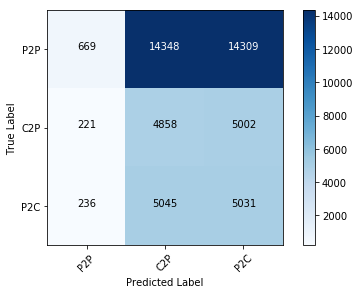

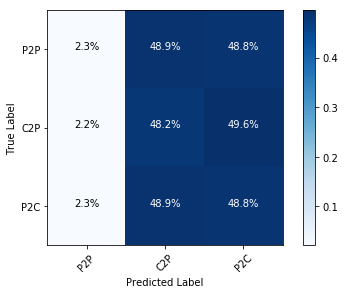

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + ToR_MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=RESULTS_PATH +ToR_MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

# Export the model to a file

In [ ]:
model_json = pairs_model.to_json()
with open(MODELS_PATH + ToR_MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
pairs_model.save_weights(MODELS_PATH + ToR_MODEL_NAME + '.h5')
print("Save Model")

# Export results to a csv file (with original ASNs)
## Define functions

In [ ]:
def index2ASN(dataset_indexed, ASN_index_map):
    dataset = []
    index_ASN_map = {index: ASN for ASN, index in ASN_index_map.iteritems()}
    for row_indexed in dataset_indexed:
        row = []
        for index in row_indexed:
            if index != 0:
                row += [index_ASN_map[index]]
        dataset.append(row)
    
    return dataset

def index2ASN_labeled(dataset_indexed, labels_indexed, ASN_index_map):
    dataset = []
    index_ASN_map = {index: ASN for ASN, index in ASN_index_map.iteritems()}
    labels_colors_map = {0:'GREEN', 1:'RED'}
    
    for i, row_indexed in enumerate(dataset_indexed):
        row = []
        for index in row_indexed:
            if index != 0:
                row += [index_ASN_map[index]]
        row += [labels_colors_map[labels_indexed[i]]]
        dataset.append(row)
    
    return dataset

import csv
def export_csv(dataset, csv_name):
    with open(csv_name + '.csv', 'wb') as csv_file:
        csv_writer = csv.writer(csv_file)
        for row in dataset:
            csv_writer.writerow(row)

## Load a relevant dataset {all, misclassified, decided, undecided} and get model predictions

In [ ]:
### misclassified from the entire dataset ###

dataset = np.load(DATA_PATH + "bgp_routes_indexed_dataset.npy")
labels = np.load(DATA_PATH + "bgp_routes_labels.npy")

# remove UNDECIDED
dataset = np.asarray([np.asarray(dataset[i]) for i in range(len(dataset)) if labels[i] != 2])
labels = np.asarray([labels[i] for i in range(len(labels)) if labels[i] != 2])

# pad sequences
dataset = sequence.pad_sequences(dataset, maxlen=max_len)
# Get Model Predictions
predictions = model.predict_classes(dataset, verbose=1)

In [ ]:
# Create misclassified dataset
x_misclassified = np.asarray([route for i,route in enumerate(dataset) if labels[i] != predictions[i]])
y_misclassified_prediction = np.asarray([label for i,label in enumerate(predictions) if labels[i] != predictions[i]])
print len(x_misclassified), len(y_misclassified_prediction)

## Export Results

In [ ]:
dataset_misclassified = index2ASN_labeled(x_misclassified, y_misclassified_prediction, ASN_index_map)
export_csv(dataset_misclassified, RESULTS_PATH + MODEL_NAME + "_misclassified")